# Comparative analysis description

# Input data description

* Barbell Graph having two cliques of 20 vertices connected with a path of 5 vertices
* A cycle of 40 vertices
* A graph consisting of 5 cliques connected by random edges with density equal to 0.002 with 100 vertices in total
* A graph consisting of 7 cliques connected by random edges with density equal to 0.03 with 100 vertices in total
* A graph consisting of 7 clusters with density 0.8 connected by random edges with density equal to 0.03 with 100 vertices in total

# Computation

In [1]:
import os
os.chdir("..")
import relegy.embeddings as rle
import relegy.metrics as rlm
import relegy.graphs as rlr
os.chdir("Analysis")

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import inspect
import copy
from IPython.display import clear_output
from matplotlib.pylab import rcParams
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys

In [3]:
def get_embedding_methods_iterable():
    """
    Iterates over embedding methods.
    """
    return filter(lambda x: x[0][:2] != "__", inspect.getmembers(sys.modules['relegy.embeddings']))

In [4]:
def generate_clusters_graph(n, k, out_density, in_density):
    """
    Generates a random graph with k clusters which sum to n vertices. The clusters have average edge density equal to in_density
    and the remaining edges between clusters have density equal to out_density.
    Returns the graph and labels corresponding to clusters
    """
    partition = np.random.multinomial(n, np.ones(k)/k, size=1)[0]
    labels = np.repeat(np.arange(k), partition)
    G = nx.Graph()
    cur_min = 0
    G2 = copy.deepcopy(G)
    for i in partition:
        ng = nx.complete_graph(range(cur_min, cur_min+i))
        G.add_nodes_from(ng)
        G2.add_nodes_from(ng)
        G2.add_edges_from(np.array(ng.edges))
        num_edges_left = np.floor(in_density*len(ng.edges)).astype(int)
        edges_ixs_left = np.random.choice(len(ng.edges), num_edges_left, replace=False)
        G.add_edges_from(np.array(ng.edges)[edges_ixs_left, :])
        cur_min += i
    G1 = nx.complement(G2)
    arr = np.arange(len(G1.edges))
    new_edges_size = np.floor(out_density*len(arr))
    new_edges = np.random.choice(arr, size=new_edges_size.astype(int))
    G.add_edges_from(np.array(G1.edges)[new_edges,:])
    return G, labels

In [5]:
#Graph generation
np.random.seed(123)
G1, labels1 = rlr.generate_graph("barbell", m1=20, m2=5), np.concatenate((np.repeat(1, 19), np.array([0, 2, 3, 4, 3, 2, 0]), np.repeat(1, 19)))
G2, labels2 = nx.cycle_graph(40), np.repeat(1, 40)
G3, labels3 = generate_clusters_graph(100, 5, 0.002, 1)
G4, labels4 = generate_clusters_graph(100, 7, 0.03, 1)
G5, labels5 = generate_clusters_graph(100, 7, 0.03, 0.8)

In [6]:
labels = [labels1, labels2, labels3, labels4, labels5]

In [7]:
#Graph plotting 
rcParams["figure.figsize"] = 8, 8
def plot_graph(graph):
    nx.draw(graph[0], node_color=graph[1])

dpdown = widgets.Dropdown(options = [('G1', (G1, labels1))], value=(G1, labels1), description="Graph: ")
with dpdown.hold_trait_notifications():
    dpdown.options=[('G1', (G1, labels1)), 
                           ('G2', (G2, labels2)), 
                           ('G3', (G3, labels3)), 
                           ('G4', (G4, labels4)), 
                           ('G5', (G5, labels5))]

interact(plot_graph, graph = dpdown)
plt.show()


interactive(children=(Dropdown(description='Graph: ', options=(('G1', (<networkx.classes.graph.Graph object at…

In [8]:
def get_results_from_all_viable_methods(d, graphs, graph_names=None):
    results = [None] * len(graphs)
    for i, G in enumerate(graphs):
        results_dictionary = {}
        for name, class_handle in get_embedding_methods_iterable():
            info = "Currently processing " + str(name) + ", d: " + str(d)
            if graph_names is not None:
                info += ", graph: " + graph_names[i]
            if not (name == "GCN" or name == "GNN"):
                if name in ["GraphWave", "HOPE", "LINE"]:
                    current_d = d // 2
                else:
                    current_d = d
                print(info)
                if not (name == "HARP"):
                    results_dictionary[name] = class_handle.fast_embed(G, d=current_d)
                    clear_output()
                else:
                    temp_name = "HARP_Deepwalk"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d)
                    temp_name = "HARP_Node2Vec"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d, method = "Node2Vec")
                    clear_output()
        results[i] = results_dictionary
    return results

In [9]:
embeddings_d2 = get_results_from_all_viable_methods(d=2, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])

In [90]:
embeddings_d6 = get_results_from_all_viable_methods(d=6, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])

In [ ]:
#niewywołane
embeddings_d20 = get_results_from_all_viable_methods(d=20, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])

In [139]:
def plot_embeddings(embeddings):
    rcParams["figure.figsize"] = 16, 16
    fig, axs = plt.subplots(4, 4)
    names = list(embeddings[0].keys())
    for i in range(len(names)):
        ix_x = i // 4
        ix_y = i % 4
        cur_Z = embeddings[0][names[i]]
        if cur_Z.shape[1] != 2:
            ss = StandardScaler().fit_transform(cur_Z)
            pca_Z = PCA(n_components=2).fit_transform(cur_Z)
            cur_Z = pca_Z
        axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=embeddings[1])
        axs[ix_x, ix_y].set_title(names[i])
        axs[ix_x, ix_y].set_xticks([])
        axs[ix_x, ix_y].set_yticks([])
    while(i < 15):
        i += 1
        ix_x = i // 4
        ix_y = i % 4
        axs[ix_x, ix_y].axis('off')
    plt.show()
        
dpdown = widgets.Dropdown(options=[('G1', (embeddings_d2[0], labels[0]))],
                                    value=(embeddings_d2[0], labels[0]),
                                    description="Graph: ")
with dpdown.hold_trait_notifications():
    dpdown.options = [('G1', (embeddings_d2[0], labels[0])), 
                       ('G2', (embeddings_d2[1], labels[1])), 
                       ('G3', (embeddings_d2[2], labels[2])), 
                       ('G4', (embeddings_d2[3], labels[3])), 
                       ('G5', (embeddings_d2[4], labels[4]))]
interact(plot_embeddings, embeddings = dpdown)
plt.show()

interactive(children=(Dropdown(description='Graph: ', options=(('G1', ({'DNGR': array([[2.2714111e-01, 9.81360…

In [8]:
def plot_embeddings(embeddings):
    rcParams["figure.figsize"] = 16, 16
    fig, axs = plt.subplots(4, 4)
    names = list(embeddings[0].keys())
    for i in range(len(names)):
        ix_x = i // 4
        ix_y = i % 4
        cur_Z = embeddings[0][names[i]]
        if cur_Z.shape[1] != 2:
            ss = StandardScaler().fit_transform(cur_Z)
            pca_Z = PCA(n_components=2).fit_transform(cur_Z)
            cur_Z = pca_Z
        axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=embeddings[1])
        axs[ix_x, ix_y].set_title(names[i])
        axs[ix_x, ix_y].set_xticks([])
        axs[ix_x, ix_y].set_yticks([])
    while(i < 15):
        i += 1
        ix_x = i // 4
        ix_y = i % 4
        axs[ix_x, ix_y].axis('off')
    plt.show()
        
dpdown = widgets.Dropdown(options=[('G1', (embeddings_d6[0], labels[0]))],
                                    value=(embeddings_d6[0], labels[0]),
                                    description="Graph: ")
with dpdown.hold_trait_notifications():
    dpdown.options = [('G1', (embeddings_d6[0], labels[0])), 
                       ('G2', (embeddings_d6[1], labels[1])), 
                       ('G3', (embeddings_d6[2], labels[2])), 
                       ('G4', (embeddings_d6[3], labels[3])), 
                       ('G5', (embeddings_d6[4], labels[4]))]
interact(plot_embeddings, embeddings = dpdown)
plt.show()

NameError: name 'embeddings_d6' is not defined

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
names = embeddings_d6[4].keys()
labels = labels4
for i, name in enumerate(names):
    Z = embeddings_d6[4][name]
    X_train, X_test, y_train, y_test = train_test_split(Z, labels, random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    print(name)
    print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
    print('Accuracy of Logistic regression classifier on test set: {:.2f}'
         .format(logreg.score(X_test, y_test)))

DNGR
Accuracy of Logistic regression classifier on training set: 0.84
Accuracy of Logistic regression classifier on test set: 0.76
DeepWalk
Accuracy of Logistic regression classifier on training set: 0.84
Accuracy of Logistic regression classifier on test set: 0.76
GraRep
Accuracy of Logistic regression classifier on training set: 0.84
Accuracy of Logistic regression classifier on test set: 0.80
GraphFactorization
Accuracy of Logistic regression classifier on training set: 0.35
Accuracy of Logistic regression classifier on test set: 0.20
GraphWave
Accuracy of Logistic regression classifier on training set: 0.19
Accuracy of Logistic regression classifier on test set: 0.16
HARP_Deepwalk
Accuracy of Logistic regression classifier on training set: 0.83
Accuracy of Logistic regression classifier on test set: 0.80
HARP_Node2Vec
Accuracy of Logistic regression classifier on training set: 0.83
Accuracy of Logistic regression classifier on test set: 0.80
HOPE
Accuracy of Logistic regression cla

C:\Users\Lukasz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TypeError: len() of unsized object

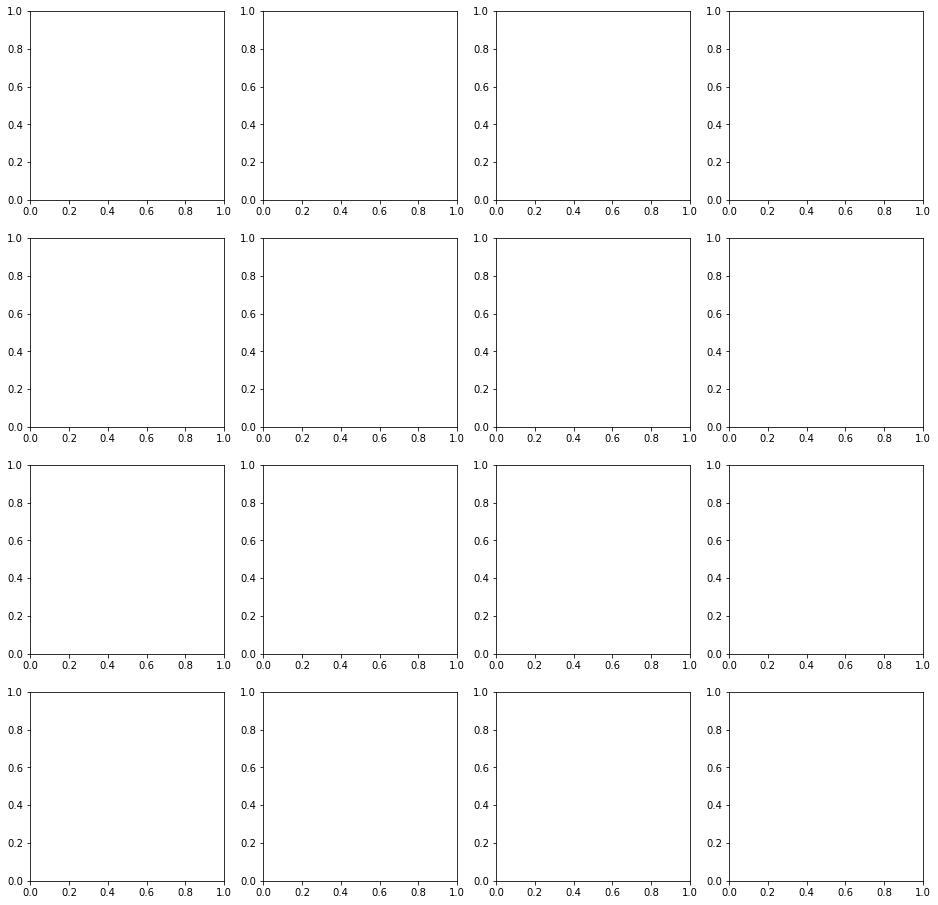

In [125]:
embeddings = (embeddings_d2[3], labels[3])
rcParams["figure.figsize"] = 16, 16
fig, axs = plt.subplots(4, 4)
names = list(embeddings[0].keys())
for i in range(len(names)):
    ix_x = i // 4
    ix_y = i % 4
    cur_Z = embeddings[0][names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=embeddings[1])
    axs[ix_x, ix_y].set_title(names[i])
    axs[ix_x, ix_y].set_xticks([])
    axs[ix_x, ix_y].set_yticks([])
while(i < 15):
    i += 1
    ix_x = i // 4
    ix_y = i % 4
    axs[ix_x, ix_y].set_xticks([])
    axs[ix_x, ix_y].set_yticks([])
    axs[ix_x, ix_y].axis('off')

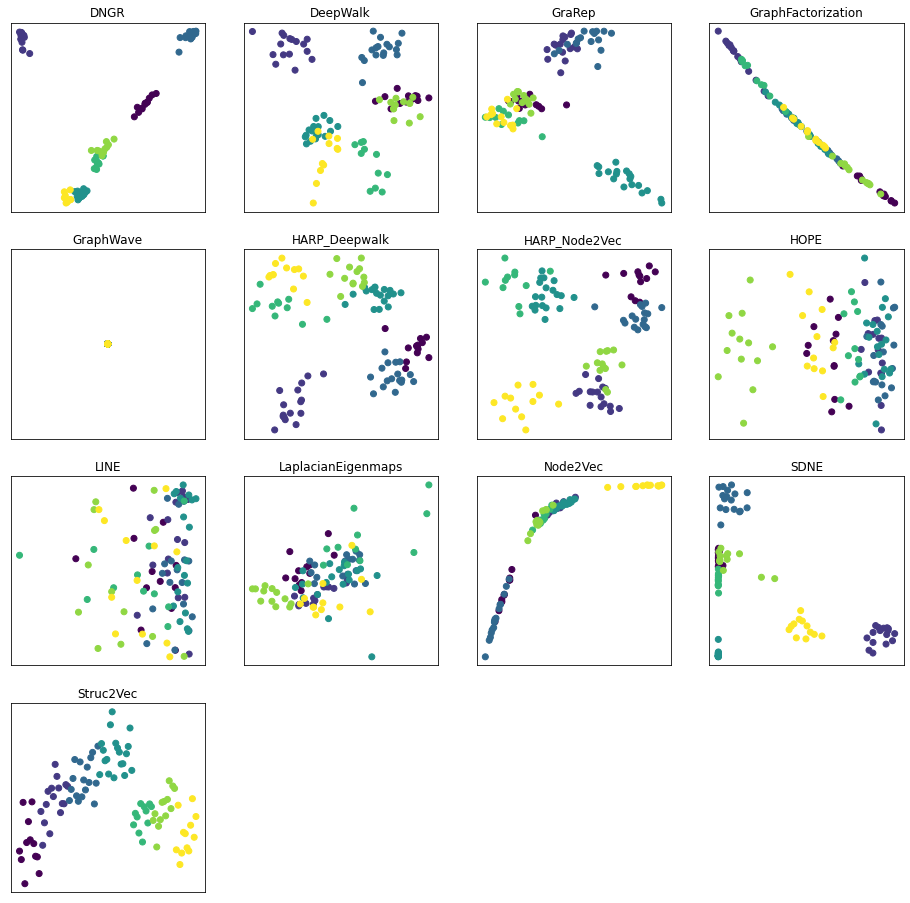

In [89]:
embeddings = (embeddings_d2[4], labels[4])
rcParams["figure.figsize"] = 16, 16
fig, axs = plt.subplots(4, 4)
names = list(embeddings[0].keys())
for i in range(len(names)):
    ix_x = i // 4
    ix_y = i % 4
    cur_Z = embeddings[0][names[i]]
    if cur_Z.shape[1] != 2:
        ss = StandardScaler().fit_transform(cur_Z)
        pca_Z = PCA(n_components=2).fit_transform(cur_Z)
        cur_Z = pca_Z
    axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=embeddings[1])
    axs[ix_x, ix_y].set_title(names[i])
    axs[ix_x, ix_y].set_xticks([])
    axs[ix_x, ix_y].set_yticks([])
while(i < 15):
    i += 1
    ix_x = i // 4
    ix_y = i % 4
    axs[ix_x, ix_y].set_xticks([])
    axs[ix_x, ix_y].set_yticks([])
    axs[ix_x, ix_y].axis('off')

In [142]:
node_labels = np.genfromtxt("C:\\Users\\Lukasz\\Desktop\\temp\\internet-industry-partnerships.node_labels")
edges = np.genfromtxt("C:\\Users\\Lukasz\\Desktop\\temp\\internet-industry-partnerships.edges", delimiter=",").astype(int)
labels1 = node_labels.astype(int)

In [145]:
G = nx.Graph()
G.add_edges_from(edges)
G = nx.convert_node_labels_to_integers(G, first_label=0)

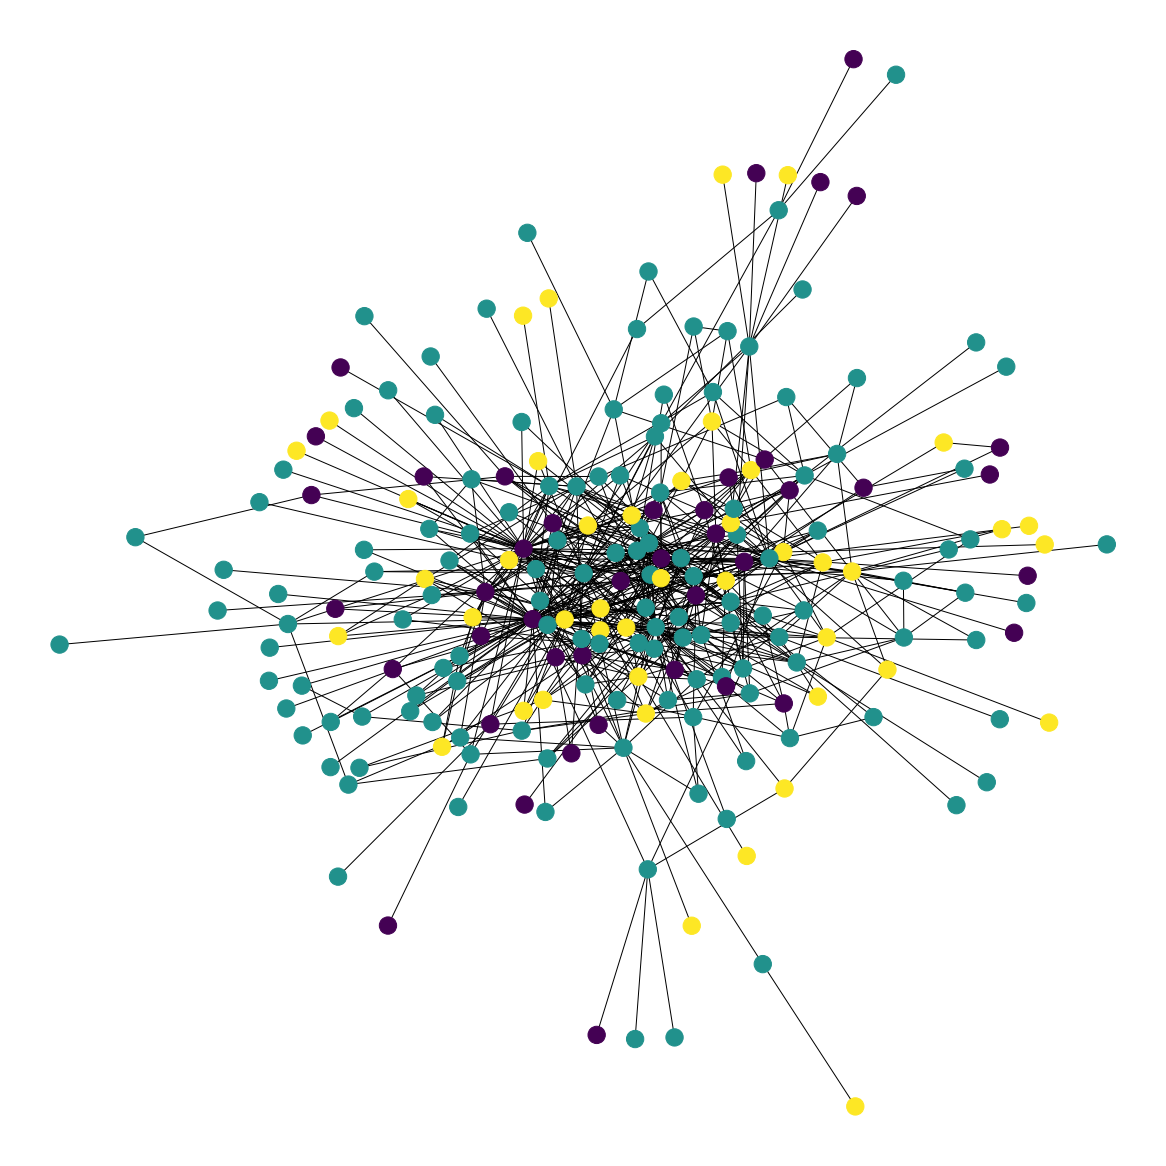

In [146]:
nx.draw(G, node_color=labels1)

In [148]:
Z = rle.GCN.fast_embed(G, labels1)

TypeError: in user code:


    TypeError: tf__build() got an unexpected keyword argument 'training'
